In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import logging
logging.getLogger('lightgbm').setLevel(logging.INFO)
logging.getLogger('lightgbm').setLevel(logging.ERROR)

In [ ]:
##The training dataset contains 20,758 entries and 18 columns. Here's a brief overview of the columns:
#id: An identifier for each row.
#Gender: The gender of the individual (Male/Female).
#Age: Age of the individual.
#Height: Height in meters.
#Weight: Weight in kilograms.
#family_history_with_overweight: Whether there is a family history of overweight.
#FAVC: Frequent consumption of high caloric food (Yes/No).
#FCVC: Frequency of consumption of vegetables.
#NCP: Number of main meals.
#CAEC: Consumption of food between meals.
#SMOKE: Smoking status.
#CH2O: Consumption of water daily.
#SCC: Calories consumption monitoring.
#FAF: Physical activity frequency.
#TUE: Time using technology devices.
#CALC: Consumption of alcohol.
#MTRANS: Main transportation mode.
#NObeyesdad: Obesity level (target variable).
#This dataset includes a mix of numerical and categorical features. The target variable, NObeyesdad, indicates the obesity level of the individual and is what we aim to predict.

# Step 1: Load Data

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
original_df = pd.read_csv("ObesityDataSet.csv")

# Step 2: Preliminary Data Check

In [3]:
train_df = train_df.drop("id", axis=1)
train_df = pd.concat([train_df, original_df], ignore_index=True)
train_df = train_df.drop_duplicates()
train_df.shape

(22845, 17)

# Step 3: Data Preparation

In [9]:
num_cols = list(train_df.select_dtypes(exclude=['object']).columns)
cat_cols = list(train_df.select_dtypes(include=['object']).columns)

num_cols_test = list(test_df.select_dtypes(exclude=['object']).columns)
cat_cols_test = list(test_df.select_dtypes(include=['object']).columns)

num_cols_test = [col for col in num_cols_test if col not in ['id']]

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols_test] = scaler.transform(test_df[num_cols_test])

In [11]:
#  object datatype columns encoding:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
object_columns = train_df.select_dtypes(include='object').columns.difference(['NObeyesdad'])

for col_name in object_columns:
    if train_df[col_name].dtypes=='object':
        train_df[col_name]=labelencoder.fit_transform(train_df[col_name])
        
for col_name in test_df.columns:
    if test_df[col_name].dtypes=='object':
        test_df[col_name]=labelencoder.fit_transform(test_df[col_name])

# Step 4: EDA

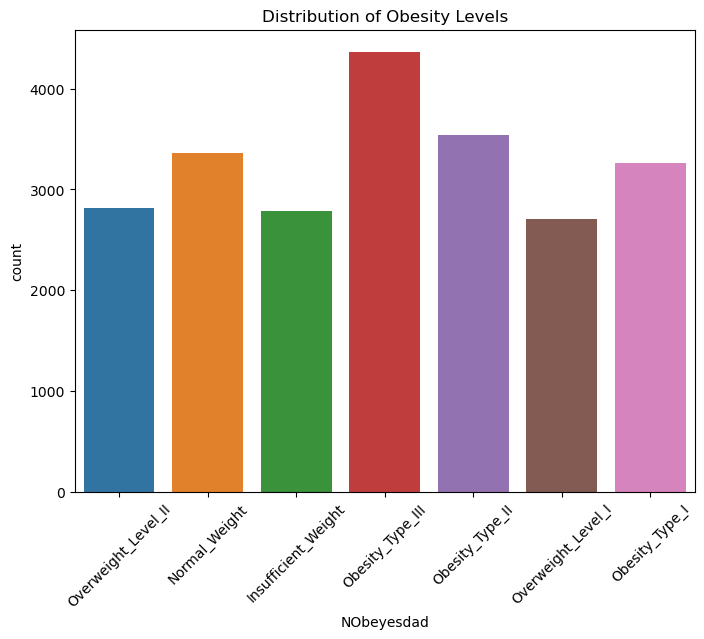

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of target classes
plt.figure(figsize=(8, 6))
sns.countplot(x='NObeyesdad', data=train_df)
plt.title('Distribution of Obesity Levels')
plt.xticks(rotation=45)
plt.show()

# Check for missing values
print(train_df.isnull().sum())

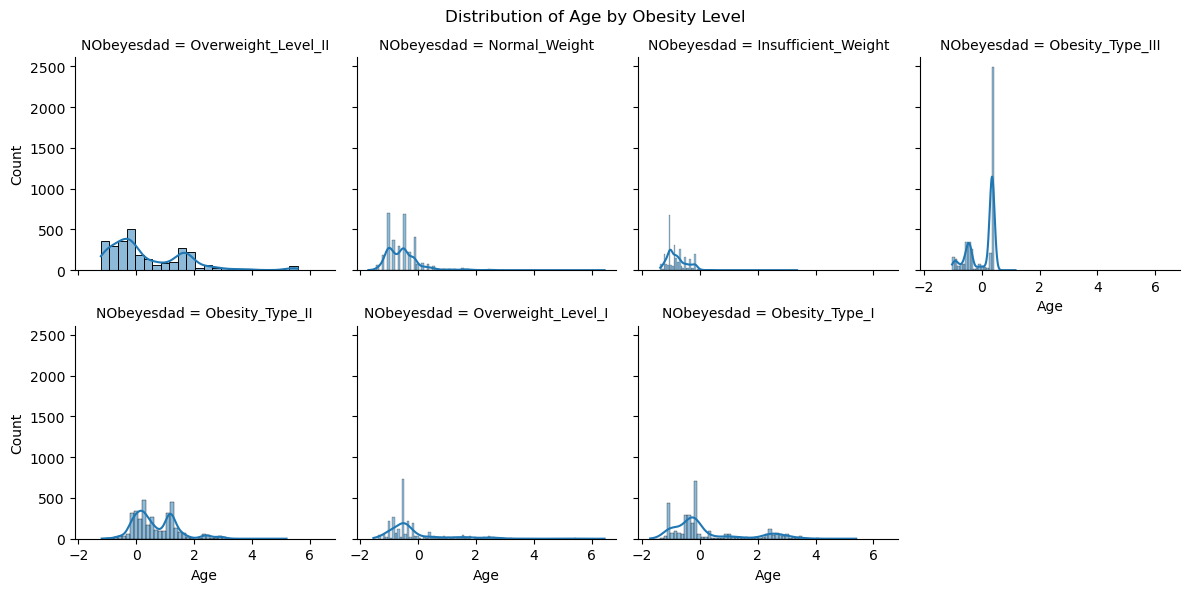

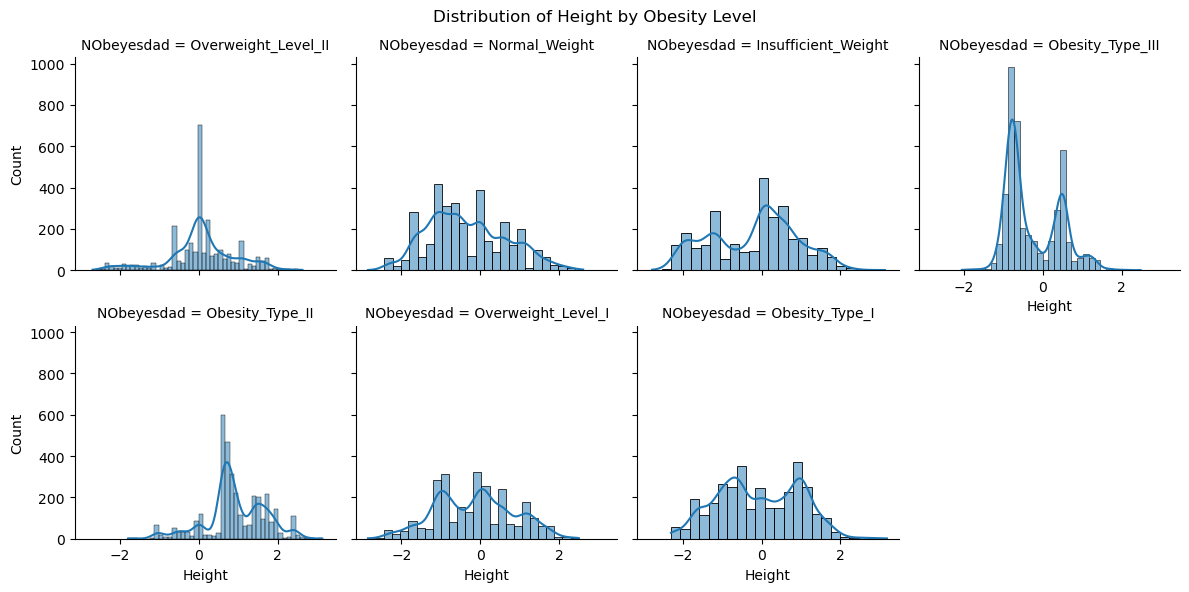

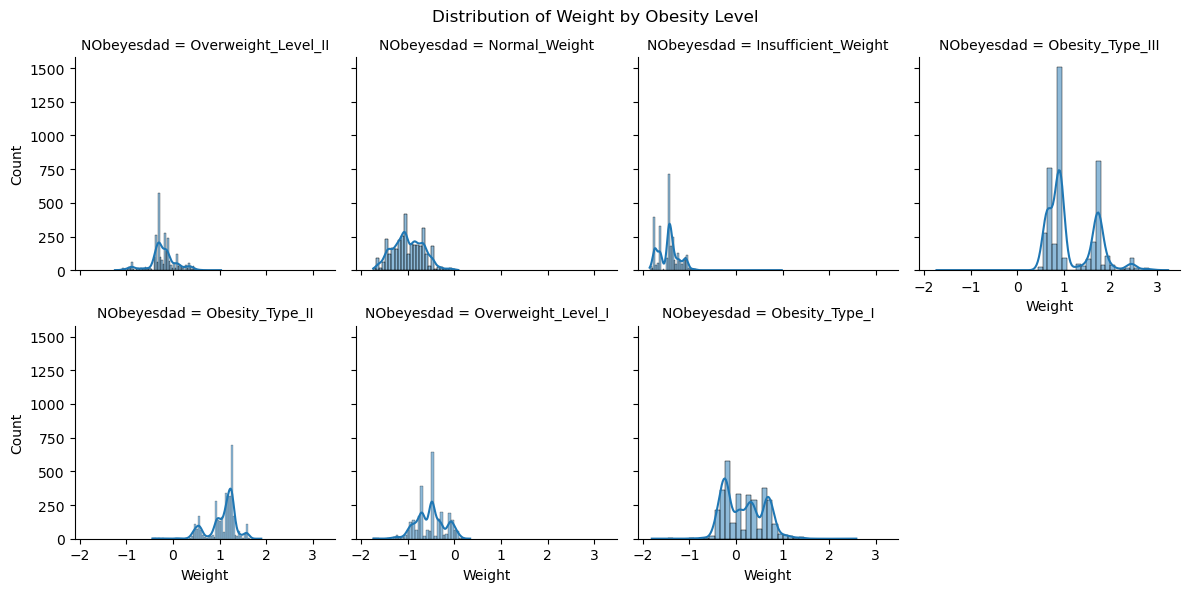

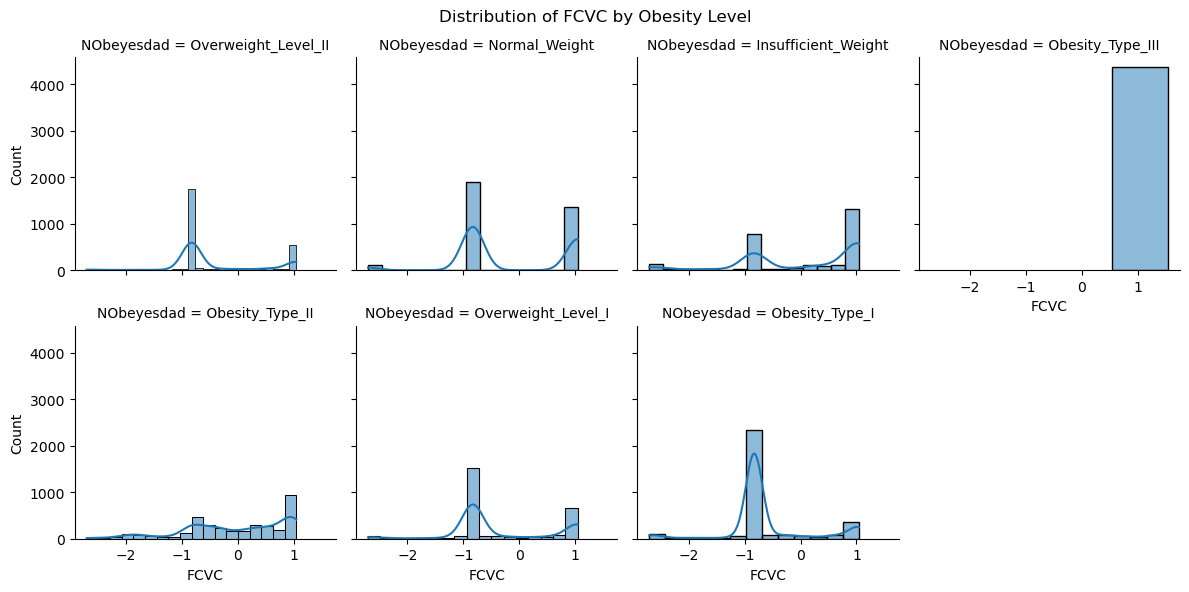

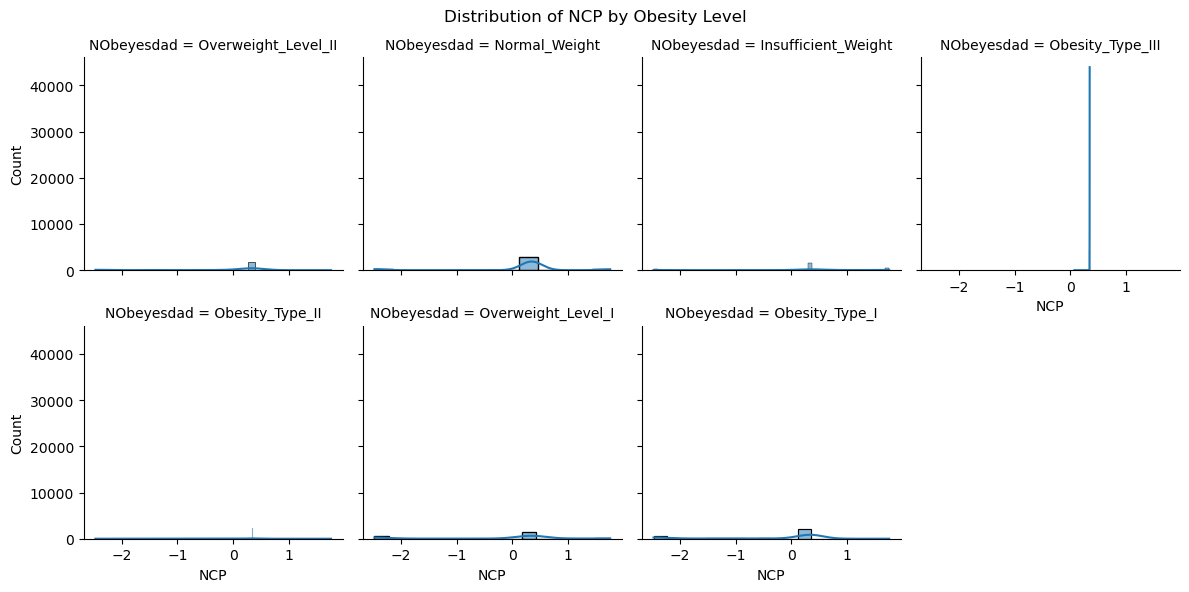

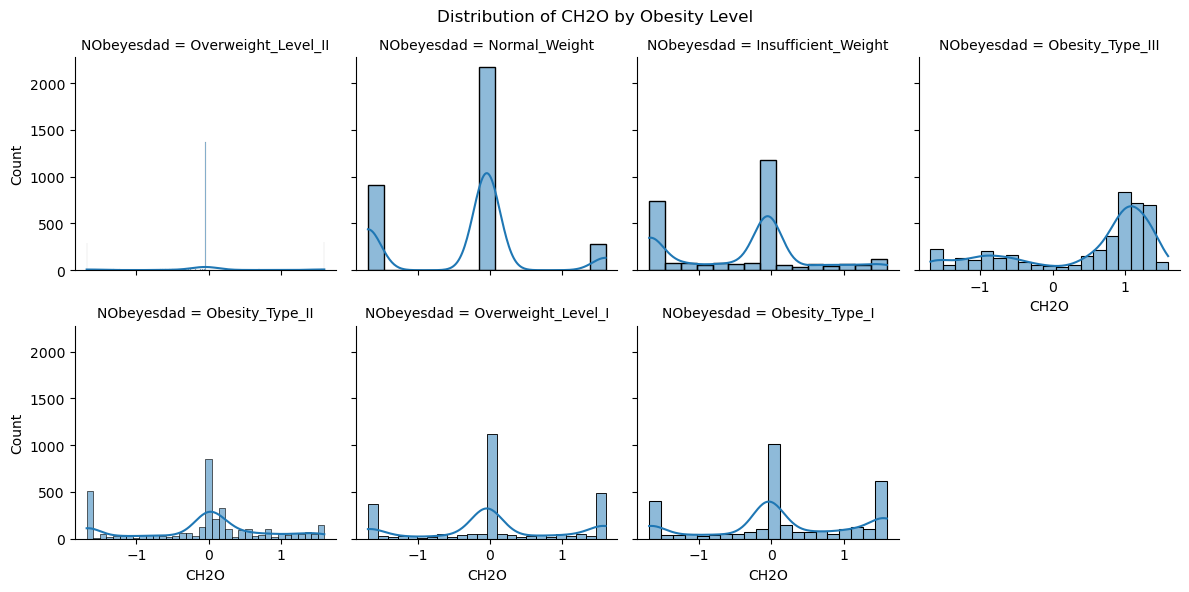

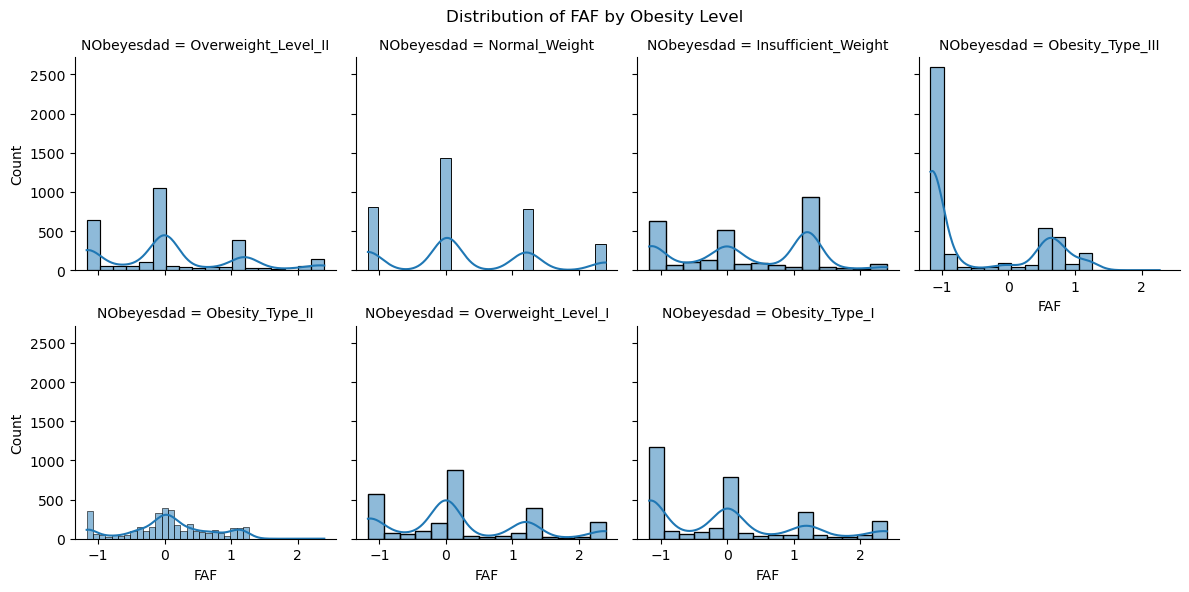

In [9]:
#Feature Distributions with Facets

import seaborn as sns
import matplotlib.pyplot as plt

# Select a few key features for detailed distribution analysis
features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF']

for feature in features:
    g = sns.FacetGrid(train_df, col='NObeyesdad', height=3, col_wrap=4)
    g.map(sns.histplot, feature, kde=True)
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Distribution of {feature} by Obesity Level')

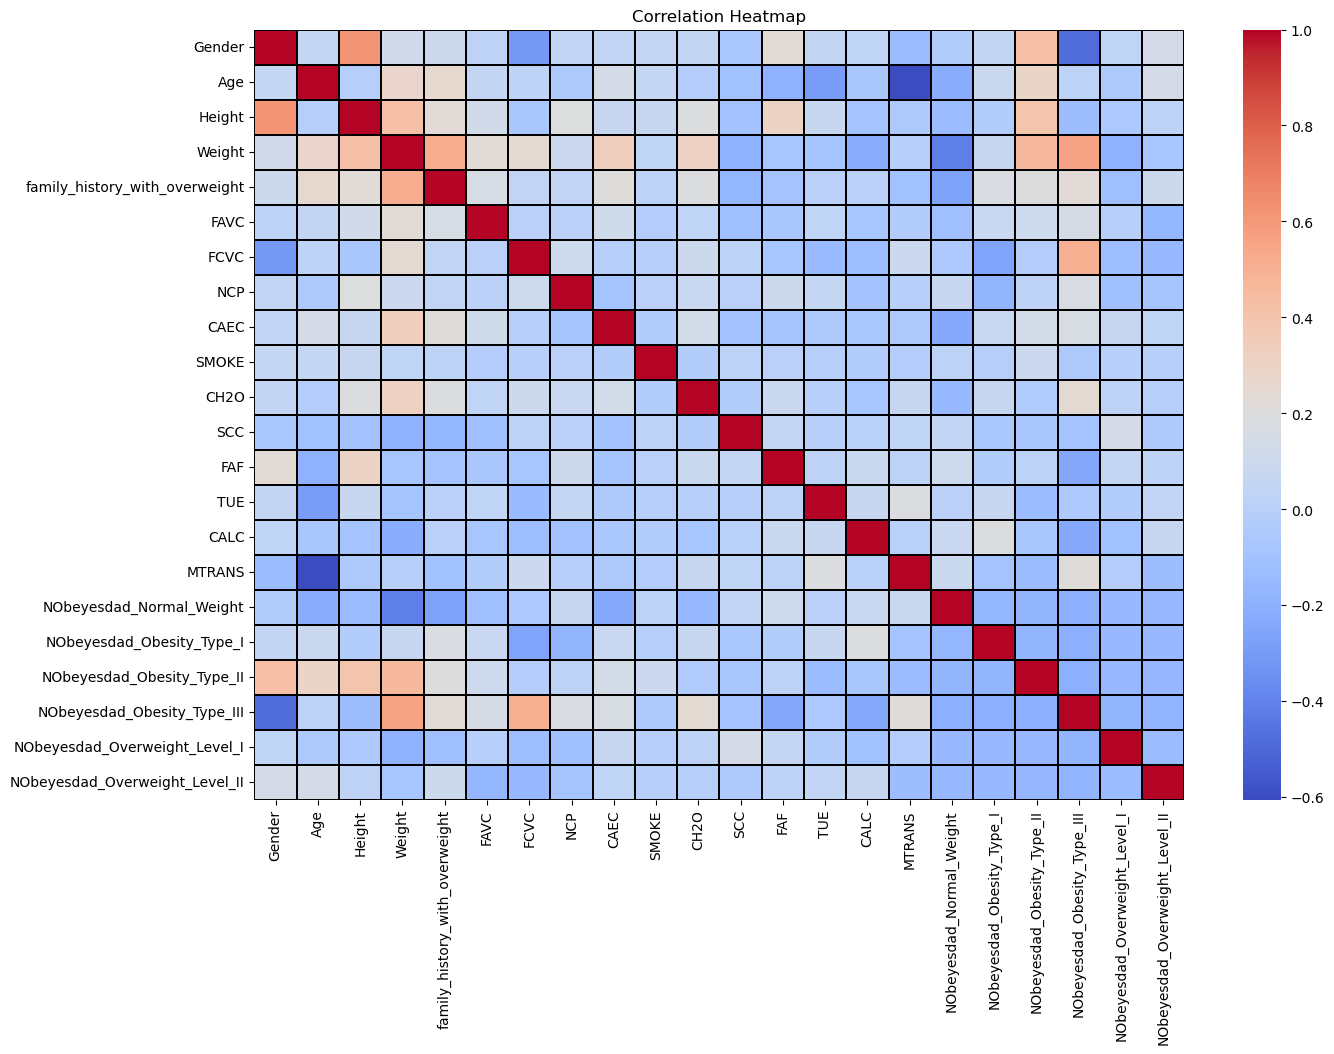

In [13]:
#Correlation Heatmaps Including Categorical Data
# Encode categorical data
encoded_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)

# Calculate the correlation matrix
corr = encoded_df.corr()

# Generate a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.1, linecolor='black')
plt.title('Correlation Heatmap')
plt.show()

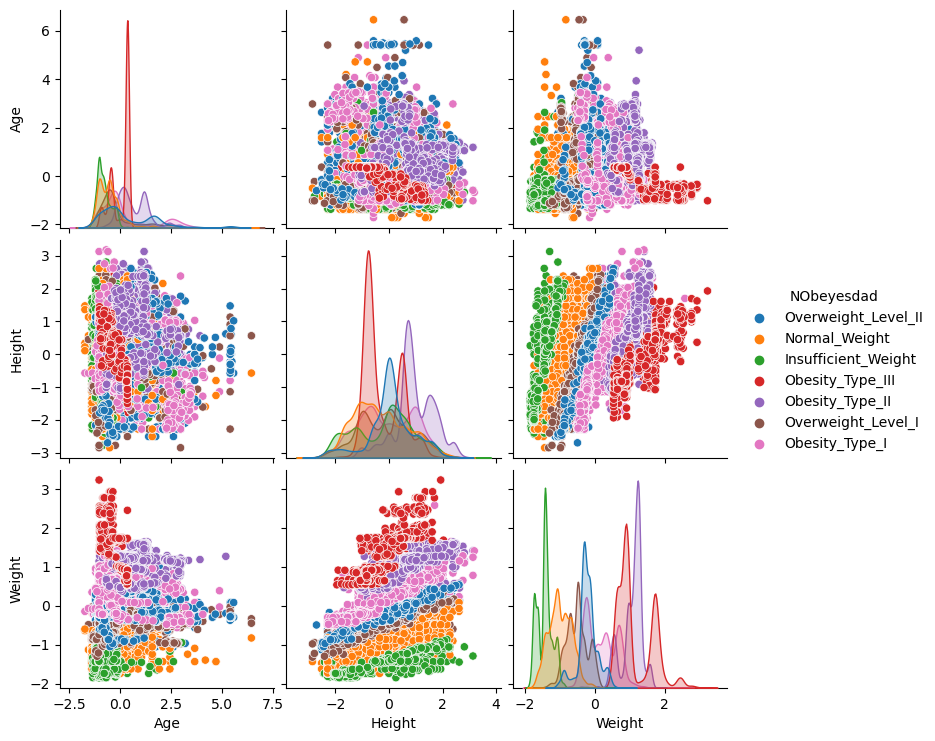

In [11]:
#Pairwise Relationships with Hue
# Use a subset of features for clarity
sns.pairplot(train_df[['Age', 'Height', 'Weight', 'NObeyesdad']], hue='NObeyesdad')
plt.show()

In [14]:
#Interactive Visualizations with Plotly
import plotly.express as px

# Interactive scatter plot of Height vs. Weight colored by Obesity Level
fig = px.scatter(train_df, x='Height', y='Weight', color='NObeyesdad',
                 title="Height vs. Weight colored by Obesity Level")
fig.show()

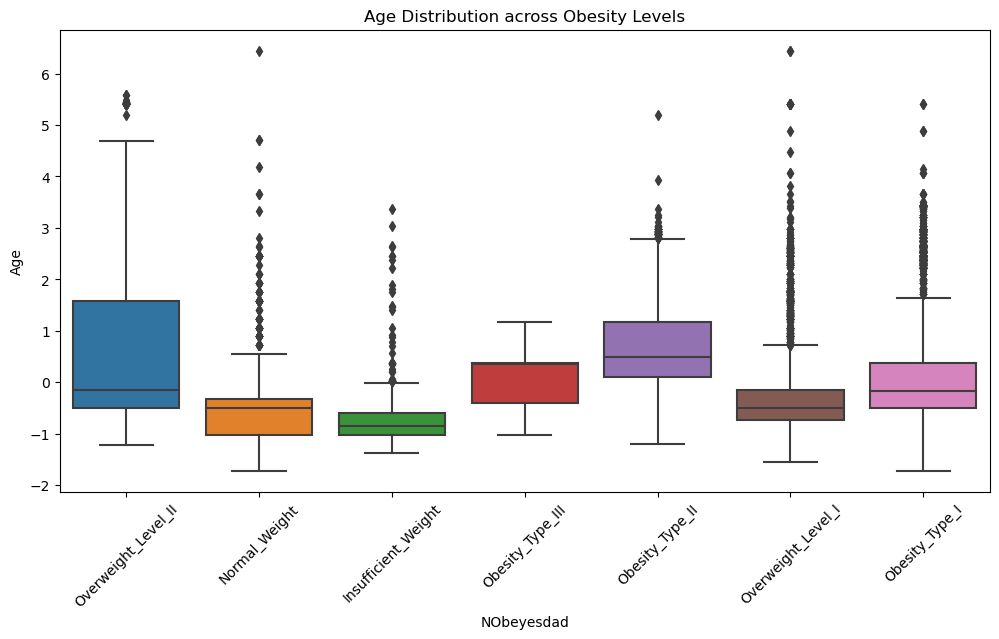

In [15]:
#Boxplots for Categorical Comparisons
# Compare distributions of Age across different levels of obesity
plt.figure(figsize=(12, 6))
sns.boxplot(x='NObeyesdad', y='Age', data=train_df)
plt.xticks(rotation=45)
plt.title('Age Distribution across Obesity Levels')
plt.show()

# Step 5 : Model Development

In [20]:
X = train_df.drop(['NObeyesdad'], axis=1)
Y = train_df['NObeyesdad']
Y = labelencoder.fit_transform(Y)
X_test = test_df.drop(["id"],axis=1)

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.2,random_state=42)

In [27]:
param = {"objective": "multiclass",          
    "metric": "multi_logloss",          
    "verbosity": -1,                    
    "boosting_type": "gbdt",            
    "random_state": 42,       
    "num_class": 7,                     
    'learning_rate': 0.030962211546832760,  
    'n_estimators': 500,                
    'lambda_l1': 0.009667446568254372,  
    'lambda_l2': 0.04018641437301800,   
    'max_depth': 10,                    
    'colsample_bytree': 0.40977129346872643,  
    'subsample': 0.9535797422450176,   
    'min_child_samples': 26}

model_lgb = lgb.LGBMClassifier(**param,verbose=100)
model_lgb.fit(X_train, Y_train)
pred_lgb = model_lgb.predict(X_val)
pred_proba = model_lgb.predict_proba(X_val)

In [33]:
import optuna

def objective(trial):
    # Define the thresholds for each class
    thresholds = {}
    for i in range(num_classes):
        thresholds[f'threshold_{i}'] = trial.suggest_uniform(f'threshold_{i}', 0.0, 1.0)

    # Apply the thresholds to convert probabilities to predictions
    Y_pred = apply_thresholds(pred_proba, thresholds)

    # Calculate accuracy
    accuracy = accuracy_score(Y_val, Y_pred)
    return accuracy  

def apply_thresholds(Y_proba, thresholds):
    # Apply the specified thresholds to convert probabilities to predicted labels
    Y_pred_labels = np.argmax(Y_proba, axis=1)
    for i in range(Y_proba.shape[1]):
        Y_pred_labels[Y_proba[:, i] > thresholds[f'threshold_{i}']] = i

    return Y_pred_labels

In [34]:
num_classes = 7
pred_proba = pred_proba  # Example: replace with actual y_pred_proba
Y_val = Y_val  # Example: replace with actual y_val

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# # Get the best thresholds
best_thresholds = study.best_params
print("Best Thresholds:", best_thresholds)

[I 2024-03-01 15:01:41,297] A new study created in memory with name: no-name-ac20e6c4-dfb1-4006-a4b0-bdc08d3311a9
[I 2024-03-01 15:01:41,305] Trial 0 finished with value: 0.8973517181002407 and parameters: {'threshold_0': 0.8016642996829447, 'threshold_1': 0.10172051056567555, 'threshold_2': 0.3144121288859786, 'threshold_3': 0.3302762620917393, 'threshold_4': 0.6928141585960537, 'threshold_5': 0.21228311706655112, 'threshold_6': 0.35254190138618813}. Best is trial 0 with value: 0.8973517181002407.
[I 2024-03-01 15:01:41,309] Trial 1 finished with value: 0.8960385204639965 and parameters: {'threshold_0': 0.22636082627499132, 'threshold_1': 0.03920617944338012, 'threshold_2': 0.04320280287843059, 'threshold_3': 0.5430492392299048, 'threshold_4': 0.8377153616918858, 'threshold_5': 0.5619430228542641, 'threshold_6': 0.6080307560887381}. Best is trial 0 with value: 0.8973517181002407.
[I 2024-03-01 15:01:41,313] Trial 2 finished with value: 0.9067629678266579 and parameters: {'threshold_0'

Best Thresholds: {'threshold_0': 0.16190779692080257, 'threshold_1': 0.5208678014914252, 'threshold_2': 0.9720959901538715, 'threshold_3': 0.4604344907449931, 'threshold_4': 0.5535774953478165, 'threshold_5': 0.7865447065798948, 'threshold_6': 0.5924912708848136}


In [35]:
threshold= {'threshold_0': 0.724201213234911, 'threshold_1': 0.6161299800571379, 'threshold_2': 0.29138887902587174, 'threshold_3': 0.3145837593497076, 'threshold_4': 0.8469398340837189, 'threshold_5': 0.6800824438387787, 'threshold_6': 0.35886959729223455}

In [36]:
test_label = model_lgb.predict_proba(X_test)
test_label = apply_thresholds(test_label, threshold)

In [37]:
pred = labelencoder.inverse_transform(test_label)
submission = pd.DataFrame({'id': test_df.id, 'NObeyesdad': pred})
submission.to_csv('submission_pallavi.csv', index=False)

# Model Evaluation and Competition Outcome Report

# WANTED TO SHARE MY ADDITIONAL WORK (Pallavi Nair_fb4097) PYTON FILE